<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/04_Common_CNN_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to common Convolutional Neural Networks Architectures
In this tutorial, we will learn about well-known CNN architectures in the field of computer vision and how to implement them in Pytorch. Moreover, we will show that some of the standard architectures are already available into the Pytorch framework. Finally, we will see how we can import and use them in our code.






In [ ]:
!pip install torchinfo

In [ ]:
# Packages
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import torchinfo
import torchvision
from torchvision import models
from torchvision import transforms


# Global variables
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Utility functions
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

def train_classifier(num_epochs, data_loader, model, criterion, optimizer, device=DEVICE):
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in data_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Forward + Backward + Optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and Accuracy
            running_loss += loss.item() * inputs.size(0)
            predicted = outputs.argmax(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader.dataset):.4f}, Accuracy: {100.*correct/total:.2f}%")

def train_denoiser(num_epochs, data_loader, model, criterion, optimizer, device=DEVICE):
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in data_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader.dataset):.4f}")

def evaluate_classifier(data_loader, model, criterion, device=DEVICE):
    model = model.to(device)
    correct = 0
    total = 0
    running_loss = 0.0

    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = outputs.argmax(1)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Loss: {running_loss/len(data_loader.dataset):.4f}")
    print(f"Test Accuracy: {100.*correct/total:.2f}%")

def evaluate_denoiser(data_loader, model, criterion, device=DEVICE):
    model = model.to(device)
    running_loss = 0.0

    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    print(f"Test Loss: {running_loss/len(data_loader.dataset):.4f}")

# CNNs in Image Classification
We start this tutorial by presenting the networks that have been widely used for image classification.  One of the most famous problems among the computer vision community was the annual software contest run by the ImageNet project, **ImageNet Large Scale Visual Recognition Challenge (ILSVRC)**. This contest evaluates how well an algorithm does in the tasks of object category classification and detection. The challenge provides hundreds of object categories and millions of images. The resolution of those images is also bigger than those on MNIST or CIFAR datasets.

As we already have seen, CIFAR10 dataset contains ten different classes of 32x32 images. We will show how to resize the data to be able to use some of the following architectures, as not all of the CNN architectures accepts arbitrary input sizes. Remember that they were designed for ImageNet, and were trained using 224x224 crops.

Let's start by loading CIFAR10:

In order to use the original models, we need to resize the CIFAR10 32x32 images into 224x224 images. However, as the whole dataset of CIFAR10 resized ot 224x224 would not fit in our RAM, we need to create a preprocessing step as we load our data. That would take the 32x32 images and, just before going into the architecture, resize them into our desired shape. To do so, we use the `transform` function in Pytorch, which applies any specified transforms (in this case `resize_images`) in a set. We can see how this function looks like for a single batch of 32 images.

In [ ]:
# Transform to resize and normalize CIFAR10 images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load CIFAR10 train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = trainset.classes

# Build data loader
train_loader = DataLoader(trainset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

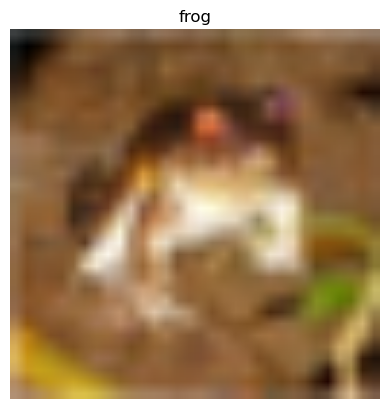

Image 0 shape: torch.Size([3, 224, 224])


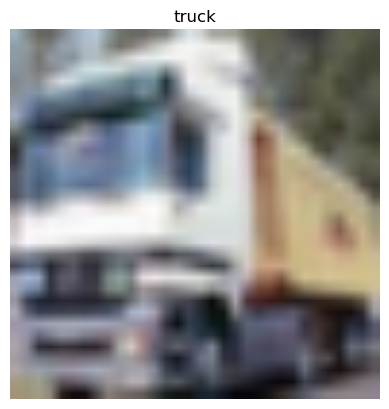

Image 1 shape: torch.Size([3, 224, 224])


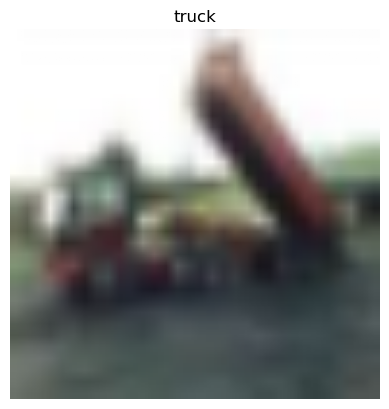

Image 2 shape: torch.Size([3, 224, 224])


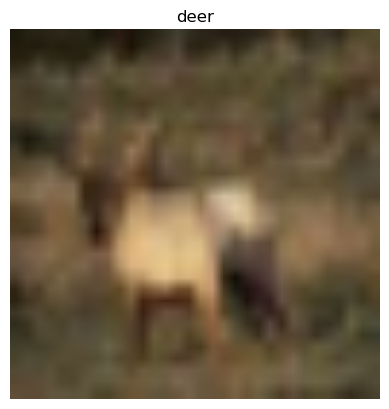

Image 3 shape: torch.Size([3, 224, 224])


In [ ]:
# Utility function to display image
def imshow(img_tensor, title=None):
    img = img_tensor.numpy().transpose((1, 2, 0))  # CHW to HWC
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display first 4 images in batch
for i in range(4):
    imshow(images[i], title=classes[labels[i]])
    print(f"Image {i} shape: {images[i].shape}")

We have the dataset and the transform function ready to use to for any of the standard classification architectures. In the next section, we will show how we can code a common architecture and train it with our preprocessed dataset.

## AlexNet

[AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) made a huge impact in 2012 in the ImageNet challenge when it reduced the top-5 error (i.e. the correct class is not among the top-5 predictions) from 26% to 15.3%. The second place was close to 26.2%, and it was not a CNN based system. AlexNet shares a lot in common with its predecessor architecture, [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) network by Yann LeCun et al. When LeNet came out, the computational complexity of the networks was an important constraint. Nowadays, with GPUs being every day more and more powerful, the computational complexity is more plausible to deal with that it was years before. Therefore, the authors in AlexNet decided to make the architecture bigger by using more convolutional layers and more filters.

The architecture proposed in their paper is as follows:

![texto alternativo](https://i.ibb.co/QFG561f/0-x-POQ3bt-Z9r-QO23-LK.png)

The network consisted of convolutional layers with kernels of size 11x11, 5x5 and 3x3. The architecture uses layers with strides, max poolings, dropouts, ReLU activation functions, and three dense layers at the very end. In their original work, the network was split into two streams, as seen in the figure above. That was because GPU constraints, and hence, the authors needed to train it on two separate GPUs. We found a great implementation in [Rizwan's blog](https://engmrk.com/alexnet-implementation-using-keras/), where it presented an AlexNet model without the split concept.

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),   # Conv1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Pool1

            nn.Conv2d(96, 256, kernel_size=11, stride=1, padding=0), # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Pool2

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=0), # Conv3
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=0), # Conv4
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=0), # Conv5
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                    # Pool5
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 4096),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
torchinfo.summary(AlexNet(10), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 96, 54, 54]           34,944
│    └─ReLU: 2-2                         [1, 96, 54, 54]           --
│    └─MaxPool2d: 2-3                    [1, 96, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 256, 17, 17]          2,973,952
│    └─ReLU: 2-5                         [1, 256, 17, 17]          --
│    └─MaxPool2d: 2-6                    [1, 256, 8, 8]            --
│    └─Conv2d: 2-7                       [1, 384, 6, 6]            885,120
│    └─ReLU: 2-8                         [1, 384, 6, 6]            --
│    └─Conv2d: 2-9                       [1, 384, 4, 4]            1,327,488
│    └─ReLU: 2-10                        [1, 384, 4, 4]            --
│    └─Conv2d: 2-11                      [1, 256, 2, 2]       

Keep in mind that we can use the original code because we have added a line of code to resize the CIFAR images from 32x32 to 224x224. We can now train our AlexNet model on CIFAR.

In [ ]:
set_seed(42)

model = AlexNet(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_classifier(3, train_loader, model, criterion, optimizer)
evaluate_classifier(test_loader, model, criterion)

Epoch [1/3] Loss: 1.7239, Accuracy: 34.70%
Epoch [2/3] Loss: 1.3039, Accuracy: 52.59%
Epoch [3/3] Loss: 1.0744, Accuracy: 62.17%
Test Loss: 1.0446
Test Accuracy: 62.99%


As it could be observed, training this kind of architectures in big datasets is time-consuming. We might need to train for several hours to start getting state-of-the-art results. That is why Pytorch saves us time and offers us several pre-trained models on the ImageNet dataset.

Those models can be used directly for image prediction, image classification, feature extraction, or fine-tuning, among others, without the need of spending long hours of training. Isn't that great!?

Even if the task or the dataset is different, using the pre-trained weights as initialisation for the training process provides usually faster convergence (and sometimes better results) than random initialisation.

# Loading Pre-trained Models in Pytorch

As mentioned, Pytorch contains many models that have been trained in the ImageNet dataset. Those models were originally released to participate in the ILSVRC competition. However, now they are available alongside their pre-trained weights and used in multiple different tasks. Using pre-trained weights has become a common practice to initialise networks. You can learn more about it [here](https://docs.pytorch.org/vision/main/models.html).

We will show how to initialise different models and load their pre-trained weights in ImageNet. Afterwards, we will show how to modify the last layer to classify only the ten classes we have in CIFAR10.

## VGGNet

VGGNet is an architecture presented by Simonyan and Zisserman in 2014. VGGNet is similar to previous AlexNet network, however, it only contains 3x3 convolutional kernels and many more filters. It has become really popular since researchers have found that it can be used to extract powerful feature representations from an image. Therefore, extracted features have proven that they are useful for many other computer vision domains and not only image classification. For instance, they can be used in feature representation, style transfer, or image captioning. You can check the [Oxford VGG paper](https://arxiv.org/pdf/1409.1556.pdf) for further details.

Next image shows the standard VGG architecture ([source](https://www.cs.toronto.edu/~frossard/post/vgg16/)):

![](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

The training time of the architecture is massive since it has more than 130 million parameters. Thankfully, we can find it already pre-trained in Pytorch. In the original work, authors proposed two versions of VGG; VGG16, and VGG19. Pytorch provides the both proposed versions, where the difference lies in the number of layers within the network.


In [ ]:
torchinfo.summary(models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

The argument `weights` indicates to Pytorch whether we need to use the pre-trained weights from ImageNet.

If we want to use the original VGG model in CIFAR10 classification, we need to change some things. The first thing to modify is the last fully connected layer. In the original VGG, the last layer is designed to classify among the 1,000 classes provided in ImageNet. In CIFAR10, as we already know, we only have ten classes. Therefore, we switch the last dense layer in the model to be able to perform classification on CIFAR10. Moreover, a common practise when using pre-trained networks is to freeze the model and only train the new dense layer. This strategy is called Transfer Learning. You can read more about it and its difference to Fine-tuning in this great [blog](https://towardsdatascience.com/cnn-transfer-learning-fine-tuning-9f3e7c5806b2). Updating only the weights of the last layer provides several advantages; faster training time, good performance, and sometimes helps the networks to not overfit in small datasets.

In [ ]:
# Load pretrained VGG16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in vgg16.parameters():
    param.requires_grad = False

# Replace classifier (fc layers)
vgg16.classifier = nn.Sequential(
    *list(vgg16.classifier.children())[:-1],  # keep up to fc2
    nn.Linear(4096, 10),                      # new output layer
)

# Check architecture
torchinfo.summary(vgg16, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

We can confirm that the original dense layer is not there anymore, and instead, we have a new fully-connected layer with only ten activations. Also, as we have frozen the weights of the model, we see that the trainable parameters of the network belong to the new dense layer.

Let's now see how we can modify the VGG architecture to use any input image shape. First of all, if we want to use any other image resolution than 224x224, we need to only use the model `features`. This argument will remove all dense layers at the end of the architecture. Remember that the dense layer comes after a flatten layer (see the model summary above) and, therefore, the size of the flatten vector is fixed. If we modify the input image size, the flatten vector would inevitably change as well. Hence, we need to redefine all dense layers within the model every time we switch the input size.

In [ ]:
# Replace classifier with custom dense layers for smaller input (32x32)
# Note: We must recalculate the flattened feature size after pooling
# For 32x32 input, VGG16 reduces it to 1x1 feature map after conv/pooling

class CustomVGG(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained VGG16 model (without top classifier layers)
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        # Freeze all the convolutional layers
        for param in vgg16.features.parameters():
            param.requires_grad = False

        self.features = vgg16.features  # only the convolutional part
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),  # 512 from final feature map size: (512, 1, 1)
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
torchinfo.summary(model = CustomVGG(), input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CustomVGG                                [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           (1,792)
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           (36,928)
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 128, 16, 16]          (73,856)
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          (147,584)
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 128, 8, 8]            --
│    └─Conv2d: 2-11                      [1, 256, 8, 8]      

We have added the same number of dense layers as in original VGG. We are ready to train the newly added layers as we did in the previous step. But first, we must prepare a new dataset to match the required input size.

In [ ]:
# Transform to normalise CIFAR-10 images (no resizing)
norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
])

# Load CIFAR-10 train and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=norm_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=norm_transform)

# Build data loaders
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
set_seed(42)

model = CustomVGG()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_classifier(3, train_loader, model, criterion, optimizer)
evaluate_classifier(test_loader, model, criterion)

Epoch [1/3] Loss: 0.9910, Accuracy: 65.32%
Epoch [2/3] Loss: 0.7835, Accuracy: 72.34%
Epoch [3/3] Loss: 0.6345, Accuracy: 77.50%
Test Loss: 0.8790
Test Accuracy: 69.93%


## GoogLeNet / Inception v1

Google presented [GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf) in 2014, the same year that VGGNet was introduced.  GoogLeNet won the ImageNet competition achieving a top-5 error rate of 6.67%, almost betting the human error rate (5%).

GoogLeNet introduced many ideas that helped the development of current state-of-the-art architectures. Instead of stacking more and more CNN layers, GoogLeNet introduced what was called inception modules:

![](https://i.ibb.co/JKqptrj/Googlenet-inception.png)

Those modules apply convolutions with 3 different sizes of kernels (1x1, 3x3 and 5x5) at the same level. The idea behind those modules is based on the premise that significant information can be presented in images at different scales. Therefore, by using a multi-scale approach, they are more likely to capture meaningful information. Moreover, they claimed that designing a wider architecture, instead of a deeper, helps the gradients to navigate throughout the entire network.

![](https://cdn-images-1.medium.com/max/1600/1*uW81y16b-ptBDV8SIT1beQ.png)

The architecture consisted of 9 inception modules stacked linearly, containing 22 deep CNN layers. However, in this network, the total number of parameters was reduced to 4 million! Authors also included two auxiliary classifiers in the middle part of the architecture to avoid the vanishing gradient problem.

Even though they won the image classification contest, original Inception v1 was a complex and heavily engineered architecture. Authors introduced many tricks to push its performance, both in terms of speed and accuracy. In the literature, we can find a constant evolution of the architecture which led to the creation of several improved versions. A list and explanation of all inception networks can be found in [this blog](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202).  

In Pytorch, the Inception model v3 architecture is available, together with its pre-trained weights on ImageNet. It can be initialised as follows:

In [ ]:
torchinfo.summary(models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True), input_size=(1, 3, 299, 299))

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [1, 1000]                 3,326,696
├─BasicConv2d: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         64
├─BasicConv2d: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         9,216
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         64
├─BasicConv2d: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         18,432
│    └─BatchNorm2d: 2-6                  [1, 64, 147, 147]         128
├─MaxPool2d: 1-4                         [1, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [1, 80, 73, 73]           --
│    └─Conv2d: 2-7                       [1, 80, 73, 73]           5,

Every network has its requirements. For instance, Inception v3 needs a minimum image input size of 75x75 due to its design. We can use the lambda function defined previously in the tutorial and see how the network performs in CIFAR10.

In [ ]:
# Create the complete model with preprocessing and new classification head
class CustomInceptionV3(nn.Module):
    def __init__(self):
        super().__init__()
        # Input preprocessing (resizing)
        self.transform = transforms.Compose([
            transforms.Resize((299, 299), interpolation=transforms.InterpolationMode.BILINEAR)
        ])

        # Create InceptionV3 model with pretrained weights
        base_model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
        # Freeze all the layers
        for param in base_model.parameters():
            param.requires_grad = False

        # Use the feature extraction part of InceptionV3
        # We need to find the layer before the fully connected layers
        # Examining the structure, the 'Mixed_7c' module seems to be the last feature extractor
        self.features = nn.Sequential(
            base_model.Conv2d_1a_3x3,
            base_model.Conv2d_2a_3x3,
            base_model.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            base_model.Conv2d_3b_1x1,
            base_model.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            base_model.Mixed_5b,
            base_model.Mixed_5c,
            base_model.Mixed_5d,
            base_model.Mixed_6a,
            base_model.Mixed_6b,
            base_model.Mixed_6c,
            base_model.Mixed_6d,
            base_model.Mixed_6e,
            base_model.Mixed_7a,
            base_model.Mixed_7b,
            base_model.Mixed_7c,
        )

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 10) # 2048 is the output channels of Mixed_7c

    def forward(self, x):
        # Apply transformations
        x = self.transform(x)
        # Extract features
        x = self.features(x)
        # Apply pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
torchinfo.summary(CustomInceptionV3(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CustomInceptionV3                        [1, 10]                   --
├─Sequential: 1-1                        [1, 2048, 8, 8]           --
│    └─BasicConv2d: 2-1                  [1, 32, 149, 149]         --
│    │    └─Conv2d: 3-1                  [1, 32, 149, 149]         (864)
│    │    └─BatchNorm2d: 3-2             [1, 32, 149, 149]         (64)
│    └─BasicConv2d: 2-2                  [1, 32, 147, 147]         --
│    │    └─Conv2d: 3-3                  [1, 32, 147, 147]         (9,216)
│    │    └─BatchNorm2d: 3-4             [1, 32, 147, 147]         (64)
│    └─BasicConv2d: 2-3                  [1, 64, 147, 147]         --
│    │    └─Conv2d: 3-5                  [1, 64, 147, 147]         (18,432)
│    │    └─BatchNorm2d: 3-6             [1, 64, 147, 147]         (128)
│    └─MaxPool2d: 2-4                    [1, 64, 73, 73]           --
│    └─BasicConv2d: 2-5                  [1, 80, 73, 73]        

Let's train Inception v3:

In [ ]:
set_seed(42)

model = CustomInceptionV3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_classifier(3, train_loader, model, criterion, optimizer)
evaluate_classifier(test_loader, model, criterion)

Epoch [1/3] Loss: 1.3781, Accuracy: 63.54%
Epoch [2/3] Loss: 0.9354, Accuracy: 70.95%
Epoch [3/3] Loss: 0.8450, Accuracy: 72.50%
Test Loss: 0.7824
Test Accuracy: 74.22%


## ResNet

In 2015, the winner of the ImageNet challenge was the Residual Neural Network ([ResNet](https://arxiv.org/pdf/1512.03385.pdf)) architecture. Similar to Inception, ResNet is built by micro-architectures modules, called residual blocks. Those blocks introduced skip connections, which allowed to train huge architectures (152 layers) while still having lower complexity than VGGNet. Thus, residual connections allowed authors to design deeper architectures since the gradient could backpropagate easier through the skip connections. Next image is from [Das' blog](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) and shows ResNet architecture with its skip connections:

![texto alternativo](https://cdn-images-1.medium.com/max/800/0*pkrso8DZa0m6IAcJ.png)

ResNet has various verions (e.g., ResNet50, ResNet101, ResNet152) with the main difference lying in the number of layers used.

In [ ]:
# Custom ResNet50 model for CIFAR-10
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Load pretrained ResNet50
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Freeze all layers
        for param in base_model.parameters():
            param.requires_grad = False

        # Remove the original classifier (fc)
        self.features = nn.Sequential(*list(base_model.children())[:-2])  # Up to last conv layer
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)          # ResNet backbone
        x = self.pool(x)              # Global Average Pooling
        x = torch.flatten(x, 1)       # Flatten
        x = self.classifier(x)        # Final Dense layer
        return x

In [ ]:
torchinfo.summary(CustomResNet50(num_classes=10), input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                        Output Shape              Param #
CustomResNet50                                [1, 10]                   --
├─Sequential: 1-1                             [1, 2048, 1, 1]           --
│    └─Conv2d: 2-1                            [1, 64, 16, 16]           (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 16, 16]           (128)
│    └─ReLU: 2-3                              [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                         [1, 64, 8, 8]             --
│    └─Sequential: 2-5                        [1, 256, 8, 8]            --
│    │    └─Bottleneck: 3-1                   [1, 256, 8, 8]            (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 8, 8]            (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 8, 8]            (70,400)
│    └─Sequential: 2-6                        [1, 512, 4, 4]            --
│    │    └─Bottleneck: 3-4                   [1, 512, 4, 4]         

Let's check the performance:

In [ ]:
set_seed(42)

model = CustomResNet50(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

train_classifier(3, train_loader, model, criterion, optimizer)
evaluate_classifier(test_loader, model, criterion)

Epoch [1/3] Loss: 1.8405, Accuracy: 36.98%
Epoch [2/3] Loss: 1.6053, Accuracy: 45.34%
Epoch [3/3] Loss: 1.5553, Accuracy: 46.62%
Test Loss: 1.5220
Test Accuracy: 49.29%


Note that all previous networks may need a different number of epochs until they converge. Even though we use pre-trained weights, fully training a model can be quite time-consuming.

## DenseNet

DenseNet, short for Densely Connected Convolutional Network, was introduced in 2017 in the paper [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993). It brought a novel concept of dense connectivity, where each layer receives the feature maps of all preceding layers as input. This approach mitigates the vanishing gradient problem, improves feature propagation, and allows for fewer parameters than traditional architectures by reusing features.

Each dense block is followed by a transition layer that performs downsampling. Compared to ResNet's additive skip connections, DenseNet concatenates the outputs of previous layers, which encourages feature reuse and compact models.

The diagram below (from the original paper) illustrates how DenseNet differs in connectivity:

![DenseNet Connectivity](https://miro.medium.com/v2/resize:fit:1400/0*7H9mNwLLWFiLYhLb.jpeg)


PyTorch offers pre-trained DenseNet models. The most popular variant is DenseNet-121, which has 121 layers, but deeper variants like DenseNet-169, 201, and 264 also exist.



In [ ]:
# Custom DenseNet121 for CIFAR-10
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Load pretrained DenseNet121
        base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

        # Freeze feature extractor layers
        for param in base_model.features.parameters():
            param.requires_grad = False

        # Replace the classifier
        self.features = base_model.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
torchinfo.summary(CustomDenseNet121(num_classes=10), input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CustomDenseNet121                        [1, 10]                   --
├─Sequential: 1-1                        [1, 1024, 1, 1]           --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           (9,408)
│    └─BatchNorm2d: 2-2                  [1, 64, 16, 16]           (128)
│    └─ReLU: 2-3                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                    [1, 64, 8, 8]             --
│    └─_DenseBlock: 2-5                  [1, 256, 8, 8]            --
│    │    └─_DenseLayer: 3-1             [1, 32, 8, 8]             (45,440)
│    │    └─_DenseLayer: 3-2             [1, 32, 8, 8]             (49,600)
│    │    └─_DenseLayer: 3-3             [1, 32, 8, 8]             (53,760)
│    │    └─_DenseLayer: 3-4             [1, 32, 8, 8]             (57,920)
│    │    └─_DenseLayer: 3-5             [1, 32, 8, 8]             (62,080)
│    │    └─_DenseLayer: 3-6             [1, 32

In [ ]:
set_seed(42)

model = CustomDenseNet121(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

train_classifier(3, train_loader, model, criterion, optimizer)
evaluate_classifier(test_loader, model, criterion)

Epoch [1/3] Loss: 1.8411, Accuracy: 35.48%
Epoch [2/3] Loss: 1.4788, Accuracy: 49.64%
Epoch [3/3] Loss: 1.3945, Accuracy: 52.24%
Test Loss: 1.3664
Test Accuracy: 53.98%


## More Architectures ...

Pytorch offers many more network implementations trained on ImageNet. You can check the [documentation](https://docs.pytorch.org/vision/main/models.html) to see all of them. Besides, the documentation reports their accuracies, number of parameters and depth of each architecture.

# CNNs for Other Tasks

Besides the success of CNNs in classification problems, CNNs have been used in many other domains. To name a few: image inpainting, facial recognition, semantic segmentation, image captioning, depth prediction, among many others. In this section, we are going to talk about two different problems in computer vision: image denoising and object detection/classification. We are aiming to provide examples of the wide applicability CNNs architectures have.


## Image Denoising with UNet

[UNet](https://arxiv.org/pdf/1505.04597.pdf) was presented in 2015 for biomedical image segmentation, but since then, it has been employed in countless different tasks, such as semantic segmentation, image colorisation, image stylisation... The UNet architectural idea is similar to a regular encoder-decoder layout but with skip connections. The first part of the network encodes the image and reduces it to a map of smaller size, forcing it to capture more global information. Then, the next part is in charge of decoding the image from that reduced feature map.

UNet uses a similar idea of the skip connections used in ResNets. In addition to helping to backpropagate the gradients, the authors used the skip connections to facilitate the flow of information between encoder and decoder. We will talk more about UNet in future tutorials, but for now, let's see how we can code an UNet model:

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.conv1 = self.double_conv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.drop4 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = self.double_conv(512, 1024)
        self.drop5 = nn.Dropout(0.5)

        # Decoder
        self.up6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.conv6 = self.double_conv(1024, 512)

        self.up7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv7 = self.double_conv(512, 256)

        self.up8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv8 = self.double_conv(256, 128)

        self.up9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv9 = self.double_conv(128, 64)

        self.conv10 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        # Encoder
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        d4 = self.drop4(c4)
        p4 = self.pool4(d4)

        c5 = self.conv5(p4)
        d5 = self.drop5(c5)

        # Decoder
        u6 = F.interpolate(d5, scale_factor=2, mode='bilinear', align_corners=True)
        u6 = self.up6(u6)
        u6 = torch.cat([u6, d4], dim=1)
        c6 = self.conv6(u6)

        u7 = F.interpolate(c6, scale_factor=2, mode='bilinear', align_corners=True)
        u7 = self.up7(u7)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)

        u8 = F.interpolate(c7, scale_factor=2, mode='bilinear', align_corners=True)
        u8 = self.up8(u8)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)

        u9 = F.interpolate(c8, scale_factor=2, mode='bilinear', align_corners=True)
        u9 = self.up9(u9)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        output = self.conv10(c9)
        return output

In [ ]:
torchinfo.summary(UNet(), input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 32, 32]            --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
├─MaxPool2d: 1-2                         [1, 64, 16, 16]           --
├─Sequential: 1-3                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-5                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-6                         [1, 128, 16, 16]          --
│    └─Conv2d: 2-7                       [1, 128, 16, 16]          147,584
│    └─ReLU: 2-8                         [1, 128, 16, 16]          --
├─MaxPool2d: 1-4                         [1, 128, 8, 8]            --

Now, we are going to create a toy example of image denoising.

We have CIFAR10 images already loaded from previous experiments. We add some Gaussian noise (you can play with the scale of the noise) to those CIFAR10 images and then train the UNet to remove that added noise from the images. To do so, we train with the noisy image as input and the clean image as the target. We use the Mean Absolute Error as the loss function to optimise the architecture.

In [ ]:
# Get full dataset tensors from DataLoader (no labels used for autoencoder)
def extract_data(loader):
    all_images = []
    for imgs, _ in loader:
        all_images.append(imgs)
    return torch.cat(all_images, dim=0)

# Step 1: Extract CIFAR-10 images from original loaders
x_train_clean = extract_data(train_loader)
x_test_clean = extract_data(test_loader)

# Step 2: Add Gaussian noise
noise_std = 0.1
x_train_noisy = x_train_clean + noise_std * torch.randn_like(x_train_clean)
x_test_noisy = x_test_clean + noise_std * torch.randn_like(x_test_clean)

# Clip to valid range [0,1] if needed (optional, depending on transforms)
x_train_noisy = torch.clamp(x_train_noisy, 0., 1.)
x_test_noisy = torch.clamp(x_test_noisy, 0., 1.)

# Step 3: Wrap as TensorDatasets
train_dataset = TensorDataset(x_train_noisy, x_train_clean)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test_noisy, x_test_clean)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
set_seed(42)

model = UNet()
criterion = nn.L1Loss()  # Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_denoiser(5, train_loader, model, criterion, optimizer)
evaluate_denoiser(test_loader, model, criterion)

Epoch [1/5] Loss: 0.7213
Epoch [2/5] Loss: 0.2342
Epoch [3/5] Loss: 0.2167
Epoch [4/5] Loss: 0.2104
Epoch [5/5] Loss: 0.2053
Test Loss: 0.1995


We can visualise the noisy image next to the output of the UNet. The output images are a little bit blurred, but the noise we added has definitely been reduced.

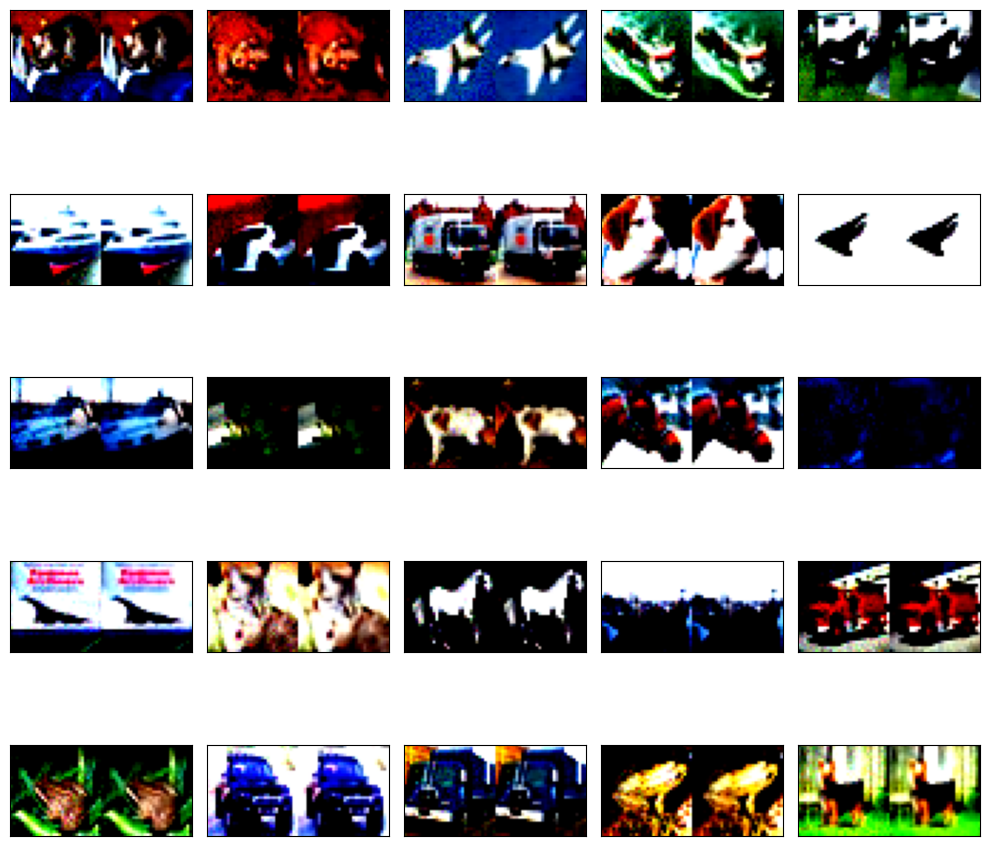

In [ ]:
def to_rgb(tensor):
    return torch.clamp(tensor, 0, 1).permute(1, 2, 0).cpu().numpy()

preds = []
model.eval()
with torch.no_grad():
    for x_noisy, _ in test_loader:
        x_noisy = x_noisy.to(DEVICE)
        output = model(x_noisy)
        preds.append(output.cpu())
pred = torch.cat(preds, dim=0)

N = 5
start_val = 0
fig, axes = plt.subplots(N, N, figsize=(10, 10))
for row in range(N):
    for col in range(N):
        idx = start_val + row + N*col
        noisy_img = to_rgb(x_test_noisy[idx])
        pred_img = to_rgb(pred[idx])
        im = np.concatenate((noisy_img, pred_img), axis=1)
        axes[row, col].imshow(im)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

plt.tight_layout()
plt.show()

## Object Detection with RetinaNet

We now will show an object detection example. Object detection differs from image classification in that in an image classification setting we give a label to the whole image, whereas in an object detection setting we give a label and bounding box per each of the classes that are present.

Top detector models include Faster R-CNN, YOLO (yes, it is called YOLO, standing for You Only Look Once; this is the unusual [resume](https://pjreddie.com/static/Redmon%20Resume.pdf) of the YOLO developer) or SSD (Single Shot Detector). Another detector is RetinaNet, which we use to give an example of object detection using the implementation based on [torchvision](https://github.com/pytorch/vision/).

In [ ]:
import torch
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
import time


SCORE_THRESHOLD = 0.45

# Load the model
weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
model = retinanet_resnet50_fpn_v2(weights=weights, box_score_thresh=SCORE_THRESHOLD)
model.eval()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Get the COCO category names
COCO_INSTANCE_CATEGORY_NAMES = weights.meta["categories"]

def draw_boxes(image, boxes, labels, scores):
    """Draw bounding boxes on the image"""
    import cv2
    image = np.array(image)
    for box, label, score in zip(boxes, labels, scores):
        # Convert box coordinates to integers
        box = box.cpu().numpy().astype(int)

        # Generate random color for this class
        color = tuple(np.random.randint(0, 255, 3).tolist())

        # Draw box
        cv2.rectangle(image,
                     (box[0], box[1]),
                     (box[2], box[3]),
                     color,
                     2)

        # Draw label
        caption = f"{COCO_INSTANCE_CATEGORY_NAMES[label]} {score:.3f}"
        cv2.putText(image,
                   caption,
                   (box[0], box[1] - 10),
                   cv2.FONT_HERSHEY_SIMPLEX,
                   0.5,
                   color,
                   2)

    return image

def detection_url(url):
    # Download and load the image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    # Prepare image for the model
    transform = weights.transforms()
    img_tensor = transform(image).to(device)

    # Perform detection
    start = time.time()
    with torch.no_grad():
        prediction = model([img_tensor])
    print("processing time: ", time.time() - start)

    # Get predictions
    boxes = prediction[0]['boxes']
    scores = prediction[0]['scores']
    labels = prediction[0]['labels']

    # Filter predictions based on score
    mask = scores > SCORE_THRESHOLD
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]

    # Draw boxes on image
    result_image = draw_boxes(image, boxes, labels, scores)

    # Display result
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(result_image)
    plt.show()

Now, we can use any *URL* pointing to an image (some *URLs* may fail) as input, and we will get an output with the detections out of the 80 classes in Microsoft COCO. If you want to check the classes available, you can print the variable labels_to_names.

As an example, we, of course, input an image full of cats. The labels are a bit blurry, but you can see all of the cats have the correct bounding box around them.

processing time:  0.07348155975341797


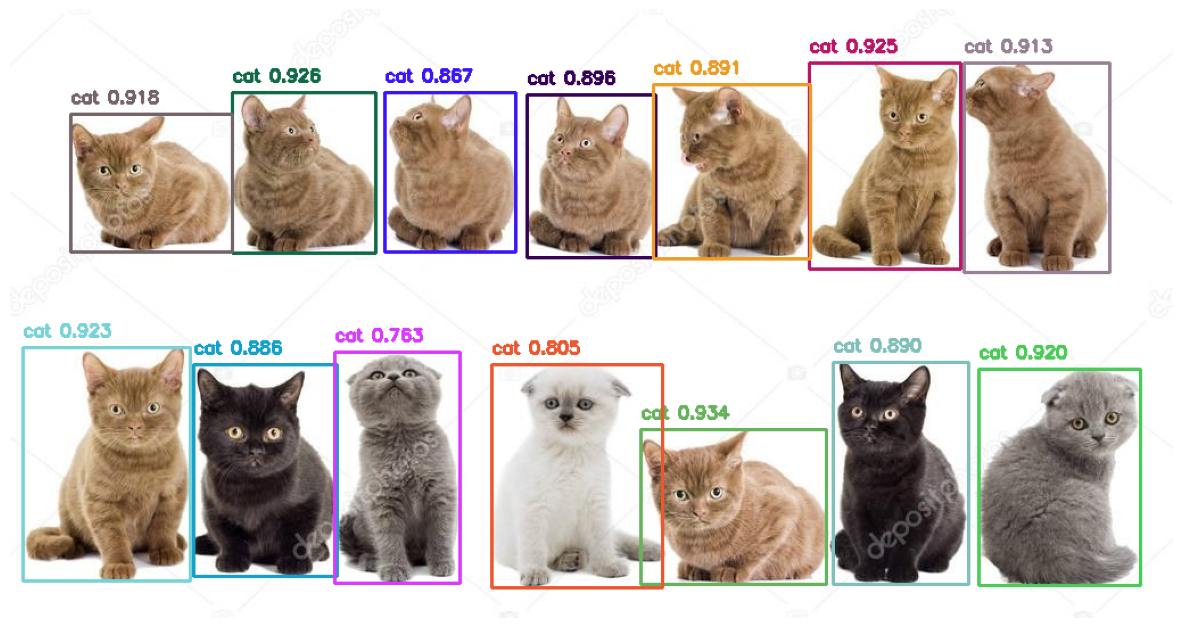

In [ ]:
url = 'https://st3.depositphotos.com/1032808/12984/i/950/depositphotos_129842732-stock-photo-group-of-various-breeds-cats.jpg'
detection_url(url)

You can even try with images that contain different classes, and see how RetinaNet deals with multi-class images.

processing time:  0.03751015663146973


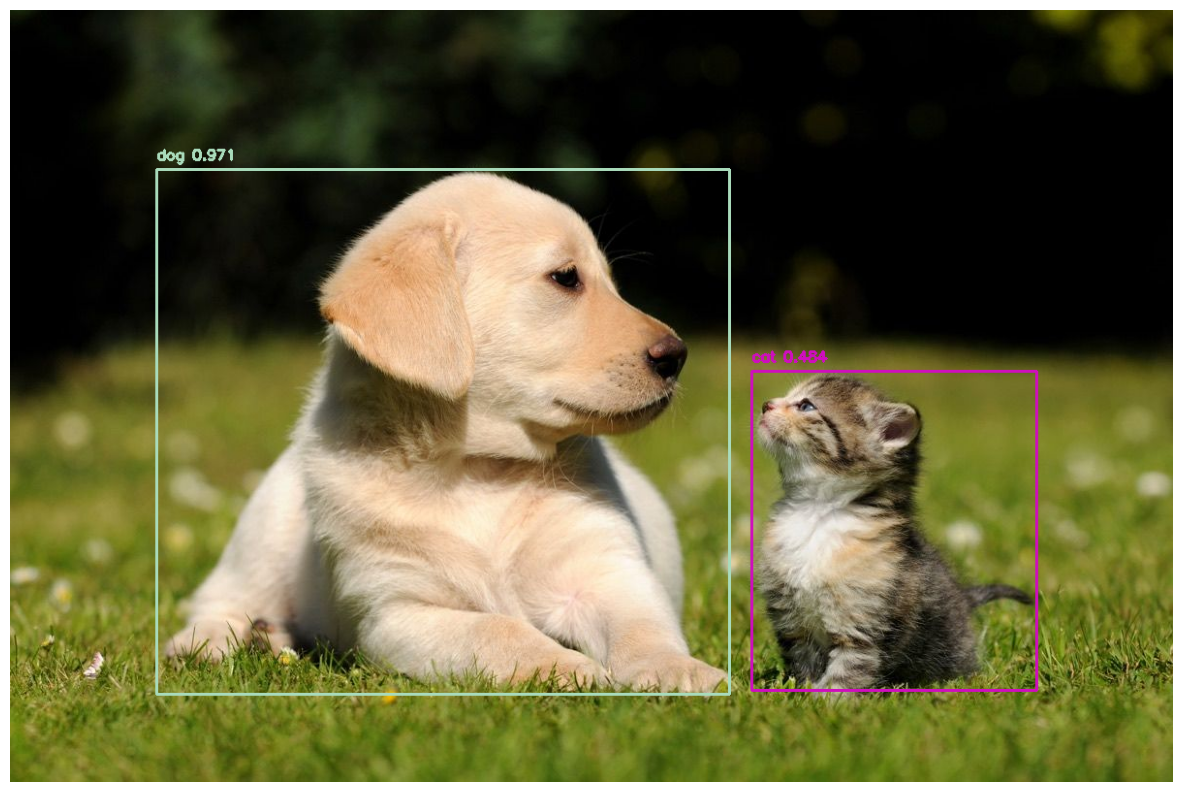

In [ ]:
url = 'https://cdn.mos.cms.futurecdn.net/hbKifQWBTcdhTEw8zsJWnF-1200-80.jpg'
detection_url(url)

# **Coursework**

## Task 1: Classification on Tiny-ImageNet

In this task, we are going to explore different models to do classification on 64x64 Tiny-ImageNet. Tiny-ImageNet is a smaller version of ImageNet (as the name indicates), containing "only" 200 classes. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 RGB images.

In the Network Training notebook, we explained how to define a validation set, and now we will put that into practice. Hence, as we now have a bigger dataset, we are going to use the standard split of training, validation, and test data. Therefore, you will check the performance of the network in the validation set while training your network. Hence, your decisions need to be based on validation performance. Once you have obtained your best model using the training and validation data, you need to report the performance on the test set. Please try to no overfit to the test data, as in other problems it may not be available to you.

In this exercise, you are asked to train VGG models with different strategies. Optionally, you are asked to use any other architecture of your choice to do classification in Tiny-ImageNet.

Run the following script to get the data.




In [ ]:
# Download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

fatal: destination path 'IMagenet' already exists and is not an empty directory.


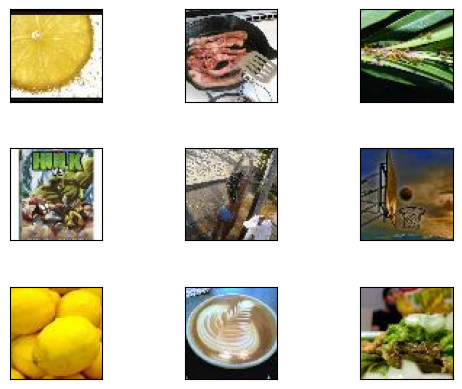

In [ ]:
def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])

    return result

def get_data(id_dict):
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    for key, value in id_dict.items():
        train_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
        train_labels += [value] * 450

        val_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450, 500)]
        val_labels += [value] * 50

    for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread(f'IMagenet/tiny-imagenet-200/val/images/{img_name}'))
        test_labels.append(id_dict[class_id])

    return np.array(train_data), np.array(train_labels), np.array(val_data), np.array(val_labels), np.array(test_data), np.array(test_labels)

def shuffle_data(train_data, train_labels, val_data, val_labels):
    # This function shuffles separately the train set and the
    # validation set
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

# Let's visualize some examples
N=3
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    tmp = cv2.cvtColor(train_data[idx],cv2.COLOR_BGR2RGB)
    axes[row,col].imshow(tmp, cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [ ]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

# Normalize to [0, 1]
train_data = torch.from_numpy(train_data).permute(0, 3, 1, 2).float() / 255.0
val_data   = torch.from_numpy(val_data).permute(0, 3, 1, 2).float() / 255.0
test_data  = torch.from_numpy(test_data).permute(0, 3, 1, 2).float() / 255.0

# Normalize to [-1, 1], channel independent
mean = train_data.mean(dim=(0, 2, 3))
std  = train_data.std(dim=(0, 2, 3))
train_data = (train_data - mean[None, :, None, None]) / (std[None, :, None, None] + 1e-7)
val_data   = (val_data   - mean[None, :, None, None]) / (std[None, :, None, None] + 1e-7)
test_data  = (test_data  - mean[None, :, None, None]) / (std[None, :, None, None] + 1e-7)

# Build data loader
train_dataset = TensorDataset(train_data, torch.from_numpy(train_labels))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(val_data, torch.from_numpy(val_labels))
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(test_data, torch.from_numpy(test_labels))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

**Report**:
*   In a plot, please report the training and validation accuracy curves for the following models:

> *   VGG16 trained from scratch.

> *   Transfer Learning VGG16: load pre-trained ImageNet weights and only train the newly added dense layers.  To do so, freeze all layers and only train the dense layers you have modified in the model.

> *   Fine-tuning VGG16: load pre-trained ImageNet weights and train the whole architecture.

*   Discuss the previous figure in the main text. And report in a table the test accuracy and the training and inference times of previous VGG16 experiments. Training times are computed per epoch and you can find them displayed in the .fit() method information. Report either the total training time, or the number of epochs and training time per epoch. Inference times are computed per image, and we give you the code below to obtain them.

*   Now that we are familiar with loading and using models in Pytorch, you can use any model of your choice to classify Tiny-ImageNet. You can take the model directly from Pytorch, any GitHub repository, or do the code yourself. You need to report your results in the previous table and compare your model of choice with previous VGG16 networks.

Note that training/inference time will depend on which GPU you are using. Report the time results in the same instance, or at least when using the same GPU. Report also the GPU you were using to compute those inference times.

Experiment: VGG16 Scratch
[VGG16 Scratch] Epoch [1/20] Train: 0.47%, Val: 0.50%, Time: 26.21s
[VGG16 Scratch] Epoch [2/20] Train: 0.44%, Val: 0.50%, Time: 26.10s
[VGG16 Scratch] Epoch [3/20] Train: 0.44%, Val: 0.50%, Time: 26.15s
[VGG16 Scratch] Epoch [4/20] Train: 0.46%, Val: 0.50%, Time: 26.20s
[VGG16 Scratch] Epoch [5/20] Train: 0.42%, Val: 0.50%, Time: 26.28s
[VGG16 Scratch] Epoch [6/20] Train: 0.43%, Val: 0.50%, Time: 26.15s
[VGG16 Scratch] Early stopping at epoch 6
[VGG16 Scratch] Test Acc: 0.50%, Avg Epoch Time: 26.18s, Inference/Image: 0.000004s

Experiment: VGG16 Transfer
[VGG16 Transfer] Epoch [1/20] Train: 24.66%, Val: 33.41%, Time: 10.95s
[VGG16 Transfer] Epoch [2/20] Train: 32.04%, Val: 36.16%, Time: 10.92s
[VGG16 Transfer] Epoch [3/20] Train: 34.54%, Val: 36.91%, Time: 11.05s
[VGG16 Transfer] Epoch [4/20] Train: 36.23%, Val: 37.58%, Time: 10.97s
[VGG16 Transfer] Epoch [5/20] Train: 37.82%, Val: 37.16%, Time: 10.98s
[VGG16 Transfer] Epoch [6/20] Train: 39.20%, Val: 37.26%,

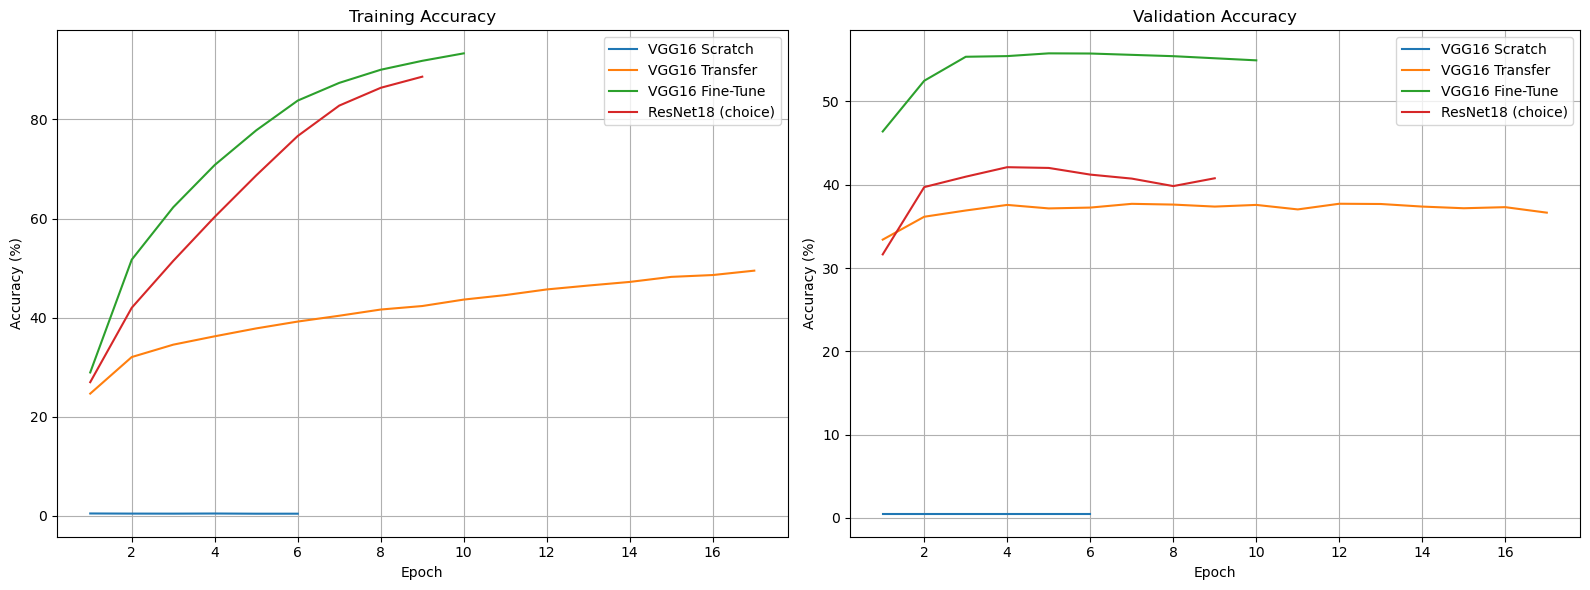


Model                  Test Acc (%)   Epochs   Avg Train Time/Ep (s)    Inference/Image (s)   
VGG16 Scratch          0.50           6        26.18                    0.000004              
VGG16 Transfer         37.59          17       11.01                    0.000004              
VGG16 Fine-Tune        55.04          10       26.16                    0.000004              
ResNet18 (choice)      41.75          9        9.57                     0.000007              
Device: NVIDIA GeForce RTX 5090


In [ ]:
import copy
import time

# Early stopping utility
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_accuracy = None
        self.best_model_weight = None

    def __call__(self, model, val_accuracy):
        if self.best_accuracy is None:
            self.best_accuracy = val_accuracy
            self.best_model_weight = copy.deepcopy(model.state_dict())
        elif val_accuracy < self.best_accuracy + self.min_delta:
            self.counter += 1
            return self.counter >= self.patience
        else:
            self.best_accuracy = val_accuracy
            self.best_model_weight = copy.deepcopy(model.state_dict())
            self.counter = 0
            return False


# =============================================================
# Model Definitions
# =============================================================

class VGG16Scratch(nn.Module):
    """VGG16 trained from scratch (random weights)."""
    def __init__(self, num_classes=200):
        super().__init__()
        self.features = models.vgg16(weights=None).features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


class VGG16Transfer(nn.Module):
    """VGG16 transfer learning: pretrained features frozen, only classifier trains."""
    def __init__(self, num_classes=200):
        super().__init__()
        base = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = base.features
        for param in self.features.parameters():
            param.requires_grad = False
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


class VGG16FineTune(nn.Module):
    """VGG16 fine-tuning: pretrained weights, all layers trainable."""
    def __init__(self, num_classes=200):
        super().__init__()
        base = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = base.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


class CustomResNet18(nn.Module):
    """ResNet18 fine-tuning (model of choice)."""
    def __init__(self, num_classes=200):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


# =============================================================
# Experiment Runner
# =============================================================

def run_experiment(model, train_loader, val_loader, test_loader,
                   num_epochs=20, lr=1e-3, patience=5, model_name="Model"):
    """Train model, track metrics, evaluate on test set."""
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=lr
    )
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-3)

    train_accs, val_accs, epoch_times = [], [], []

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        train_correct = 0
        t0 = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_correct += (outputs.argmax(1) == labels).sum().item()
        epoch_time = time.time() - t0

        # --- Validation ---
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = 100.0 * train_correct / len(train_loader.dataset)
        val_acc = 100.0 * val_correct / len(val_loader.dataset)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        epoch_times.append(epoch_time)

        print(
            f"[{model_name}] Epoch [{epoch+1}/{num_epochs}] "
            f"Train: {train_acc:.2f}%, Val: {val_acc:.2f}%, "
            f"Time: {epoch_time:.2f}s"
        )

        if early_stopping(model, val_acc):
            print(f"[{model_name}] Early stopping at epoch {epoch+1}")
            break

    # Restore best model
    model.load_state_dict(early_stopping.best_model_weight)

    # --- Test Evaluation ---
    model.eval()
    test_correct = 0
    inference_time = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            t0 = time.time()
            outputs = model(inputs)
            inference_time += time.time() - t0
            test_correct += (outputs.argmax(1) == labels).sum().item()

    test_acc = 100.0 * test_correct / len(test_loader.dataset)
    time_per_image = inference_time / len(test_loader.dataset)
    avg_epoch_time = np.mean(epoch_times)

    print(
        f"[{model_name}] Test Acc: {test_acc:.2f}%, "
        f"Avg Epoch Time: {avg_epoch_time:.2f}s, "
        f"Inference/Image: {time_per_image:.6f}s\n"
    )

    return {
        "train_acc": train_accs,
        "val_acc": val_accs,
        "test_acc": test_acc,
        "avg_epoch_time": avg_epoch_time,
        "total_epochs": len(train_accs),
        "time_per_image": time_per_image,
    }


# =============================================================
# Run All Experiments
# =============================================================

experiments = [
    ("VGG16 Scratch",       VGG16Scratch(200),    1e-3),
    ("VGG16 Transfer",      VGG16Transfer(200),   1e-3),
    ("VGG16 Fine-Tune",     VGG16FineTune(200),   1e-4),
    ("ResNet18 (choice)",   CustomResNet18(200),  1e-3),
]

results = {}
for name, mdl, lr in experiments:
    set_seed(42)
    print("=" * 60)
    print(f"Experiment: {name}")
    print("=" * 60)
    results[name] = run_experiment(
        mdl, train_loader, val_loader, test_loader,
        num_epochs=20, lr=lr, model_name=name,
    )

# =============================================================
# Plot Training & Validation Accuracy Curves
# =============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for name, res in results.items():
    epochs = range(1, len(res["train_acc"]) + 1)
    axes[0].plot(epochs, res["train_acc"], label=name)
    axes[1].plot(epochs, res["val_acc"], label=name)

axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title("Training Accuracy"); axes[0].legend(); axes[0].grid(True)
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Validation Accuracy"); axes[1].legend(); axes[1].grid(True)
plt.tight_layout()
plt.show()

# =============================================================
# Results Table
# =============================================================

print("\n" + "=" * 95)
print(
    f"{'Model':<22} {'Test Acc (%)':<14} {'Epochs':<8} "
    f"{'Avg Train Time/Ep (s)':<24} {'Inference/Image (s)':<22}"
)
print("=" * 95)
for name, res in results.items():
    print(
        f"{name:<22} {res['test_acc']:<14.2f} {res['total_epochs']:<8} "
        f"{res['avg_epoch_time']:<24.2f} {res['time_per_image']:<22.6f}"
    )
print("=" * 95)
gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
print(f"Device: {gpu_name}")

## Task 2: ConvNeXt Model Scaling on Tiny-ImageNet
ConvNeXt is a modern convolutional neural network architecture introduced by Facebook AI Research in the 2022 paper titled "[A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545)" by Liu et al. It reimagines the classic ResNet architecture by integrating design principles from Vision Transformers (ViTs), such as large kernel sizes, inverted bottlenecks, depthwise convolutions, Layer Normalization, and GELU activations. Despite being fully convolutional, ConvNeXt matches or even surpasses the performance of transformer-based models like the Swin Transformer on benchmarks such as ImageNet. Its success demonstrated that, with the right architectural updates, CNNs can remain competitive in the transformer era, significantly influencing how researchers view the future of convolutional models in computer vision.

Pytorch offers pretrained model architecture for ConvNeXt at varying sizes, which can be seen [here](https://docs.pytorch.org/vision/main/models/convnext.html).

In this task, we explore how increasing model size affects performance while keeping architecture the same. You will load ConvNeXt-Tiny, Small, Base, and Large pretrained on ImageNet, and evaluate them on the previously loaded TinyImageNet data to investigate the tradeoff in performance for size constraints.

*Note: You are NOT training or fine-tuning these models.*

Use the code below to load the data in the format required by the models.

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

# Define transforms for ConvNeXt input (resize to 224, normalize like ImageNet)
convnext_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Reload raw test images from disk as PIL for proper transform pipeline
# (test_data from cell 65 is already a normalized tensor, not suitable for ConvNeXt transforms)
id_dict = get_id_dictionary()
test_images_pil = []
test_labels_task2 = []
for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
    img_name, class_id = line.split('\t')[:2]
    img = Image.open(f'IMagenet/tiny-imagenet-200/val/images/{img_name}').convert('RGB')
    test_images_pil.append(img)
    test_labels_task2.append(id_dict[class_id])

test_labels_task2 = np.array(test_labels_task2)

class TinyImageNetTestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels  # already integer class indices (0-199)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

test_dataset = TinyImageNetTestDataset(test_images_pil, test_labels_task2, transform=convnext_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Task 2 test set: {len(test_dataset)} images, {len(set(test_labels_task2.tolist()))} classes")

Task 2 test set: 10000 images, 200 classes


Mapped 200/200 TinyImageNet classes to ImageNet indices.

Evaluating ConvNeXt-Tiny ...
  ConvNeXt-Tiny: Accuracy=70.32%, MSE=0.427929, Params=28,589,128

Evaluating ConvNeXt-Small ...
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /home/zz4723/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth


100%|██████████| 192M/192M [00:04<00:00, 40.4MB/s] 


  ConvNeXt-Small: Accuracy=72.49%, MSE=0.401595, Params=50,223,688

Evaluating ConvNeXt-Base ...
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /home/zz4723/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:03<00:00, 114MB/s] 


  ConvNeXt-Base: Accuracy=75.74%, MSE=0.369757, Params=88,591,464

Evaluating ConvNeXt-Large ...
Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /home/zz4723/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


100%|██████████| 755M/755M [00:06<00:00, 114MB/s] 


  ConvNeXt-Large: Accuracy=77.28%, MSE=0.335127, Params=197,767,336


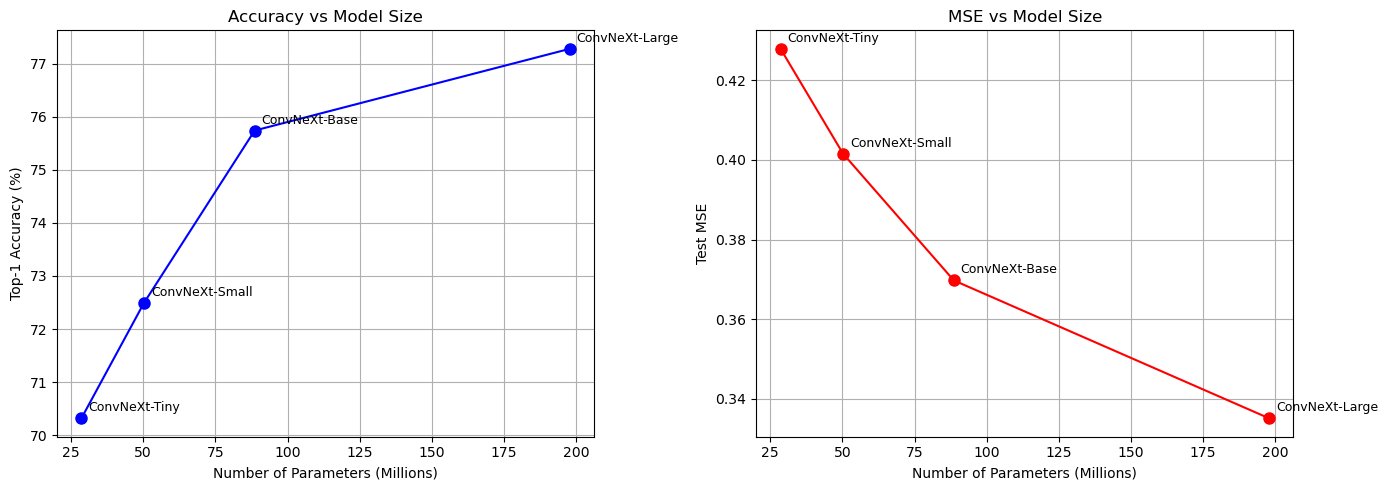


Model              Params (M)     Accuracy (%)     MSE         
ConvNeXt-Tiny      28.6           70.32            0.427929    
ConvNeXt-Small     50.2           72.49            0.401595    
ConvNeXt-Base      88.6           75.74            0.369757    
ConvNeXt-Large     197.8          77.28            0.335127    


In [ ]:
import json
import urllib.request
import torch.nn.functional as F  # Re-import (cell 56 shadows F with torchvision.transforms.functional)

def fit_model_head(model, num_classes=200):
    # Replace the classifier head to match Tiny-ImageNet classes
    num_ftrs = model.classifier[2].in_features  # ConvNeXt classifier is nn.Sequential(..., nn.Linear)
    model.classifier[2] = nn.Linear(num_ftrs, num_classes)
    return model


# =============================================================
# Build TinyImageNet -> ImageNet class mapping
# =============================================================
# TinyImageNet's 200 classes are a subset of ImageNet's 1000 classes.
# We map TinyImageNet indices (0-199) to ImageNet indices (0-999) so
# we can evaluate pretrained 1000-class models directly.

# Download the standard ImageNet class index: {idx: [wnid, name]}
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with urllib.request.urlopen(url) as resp:
    imagenet_class_idx = json.loads(resp.read().decode())

# wnid -> imagenet class index
wnid_to_imagenet_idx = {v[0]: int(k) for k, v in imagenet_class_idx.items()}

# Map: tinyimagenet_idx (0-199) -> imagenet_idx (0-999)
id_dict = get_id_dictionary()  # wnid -> tinyimagenet_idx
tiny_to_imagenet = {}
for wnid, tiny_idx in id_dict.items():
    if wnid in wnid_to_imagenet_idx:
        tiny_to_imagenet[tiny_idx] = wnid_to_imagenet_idx[wnid]

# Ordered list: position i holds the ImageNet index for TinyImageNet class i
imagenet_indices = [tiny_to_imagenet[i] for i in range(200)]
imagenet_indices_tensor = torch.tensor(imagenet_indices, device=DEVICE)

print(f"Mapped {len(tiny_to_imagenet)}/200 TinyImageNet classes to ImageNet indices.")


# =============================================================
# Evaluate ConvNeXt models (Tiny, Small, Base, Large)
# =============================================================

convnext_configs = [
    ("ConvNeXt-Tiny",  models.convnext_tiny,  models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1),
    ("ConvNeXt-Small", models.convnext_small, models.ConvNeXt_Small_Weights.IMAGENET1K_V1),
    ("ConvNeXt-Base",  models.convnext_base,  models.ConvNeXt_Base_Weights.IMAGENET1K_V1),
    ("ConvNeXt-Large", models.convnext_large, models.ConvNeXt_Large_Weights.IMAGENET1K_V1),
]

convnext_results = {}

for name, model_fn, weights in convnext_configs:
    print(f"\nEvaluating {name} ...")
    model = model_fn(weights=weights).to(DEVICE)
    model.eval()

    num_params = sum(p.numel() for p in model.parameters())

    correct = 0
    total = 0
    mse_total = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)                           # (B, 1000)

            # Select only the 200 outputs corresponding to TinyImageNet classes
            relevant = outputs[:, imagenet_indices_tensor]    # (B, 200)

            # Top-1 accuracy among the 200 relevant classes
            preds = relevant.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # MSE between softmax probabilities and one-hot targets
            probs = F.softmax(relevant, dim=1)
            one_hot = F.one_hot(labels, num_classes=200).float()
            mse_total += F.mse_loss(probs, one_hot, reduction="sum").item()

    accuracy = 100.0 * correct / total
    mse = mse_total / total

    convnext_results[name] = {
        "accuracy": accuracy,
        "mse": mse,
        "num_params": num_params,
    }
    print(f"  {name}: Accuracy={accuracy:.2f}%, MSE={mse:.6f}, Params={num_params:,}")


# =============================================================
# Plot: Accuracy & MSE vs Number of Parameters
# =============================================================

names  = list(convnext_results.keys())
params = [convnext_results[n]["num_params"] / 1e6 for n in names]
accs   = [convnext_results[n]["accuracy"]   for n in names]
mses   = [convnext_results[n]["mse"]        for n in names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(params, accs, "bo-", markersize=8)
for i, n in enumerate(names):
    ax1.annotate(n, (params[i], accs[i]), textcoords="offset points", xytext=(5, 5), fontsize=9)
ax1.set_xlabel("Number of Parameters (Millions)")
ax1.set_ylabel("Top-1 Accuracy (%)")
ax1.set_title("Accuracy vs Model Size")
ax1.grid(True)

ax2.plot(params, mses, "ro-", markersize=8)
for i, n in enumerate(names):
    ax2.annotate(n, (params[i], mses[i]), textcoords="offset points", xytext=(5, 5), fontsize=9)
ax2.set_xlabel("Number of Parameters (Millions)")
ax2.set_ylabel("Test MSE")
ax2.set_title("MSE vs Model Size")
ax2.grid(True)

plt.tight_layout()
plt.show()

# =============================================================
# Summary Table
# =============================================================

print("\n" + "=" * 70)
print(f"{'Model':<18} {'Params (M)':<14} {'Accuracy (%)':<16} {'MSE':<12}")
print("=" * 70)
for n in names:
    r = convnext_results[n]
    print(f"{n:<18} {r['num_params']/1e6:<14.1f} {r['accuracy']:<16.2f} {r['mse']:<12.6f}")
print("=" * 70)

**Report**:
*   In a plot, report the accuracy and test MSE against number of parameters of the model.

*   Discuss the previous figure(s) in the main text, explaining the trend seen between model size and performance and comment on the benefits/drawbacks of using a larger/smaller model.
